In [1]:
from scipy.stats import chi2_contingency
import cogent3
from cogent3 import get_app
import matplotlib.pyplot as plt
import paths
import libs
import pandas as pd
import numpy as np

## Intergenic Ancestral Repeats (IGAR)

In [2]:
folder_in = paths.DATA_APES114 + 'intergenicAR/'
in_dstore = cogent3.open_data_store(folder_in, suffix='fa', mode='r')

#loading and cocatanating sequences
#rename_noncds eliminates files that do not contain Gorilla, Human and Chimp sequences or that has duplicates.
loader = get_app("load_aligned", moltype="dna")
omit_degs_noncds = get_app("omit_degenerates", moltype="dna")
rename_noncds = libs.renamer_noncds_aligned()
concat = get_app("concat", moltype="dna")

noncds_app = loader + omit_degs_noncds + rename_noncds

nonconcat_IGAR = [r for r in noncds_app.as_completed(in_dstore[:], parallel=True) if r]
alns_IGAR = concat(nonconcat_IGAR)
alns_IGAR.source = "IGAR_alignments"

#Do a General nucleotide substitution model.
#The branches of the Gorilla are discretize to avoid double counting substitutions.
#This leads to refined Chimp and Human estimates although crappy Gorilla estimates. Do not trusth Gorilla values
GN_subsmodel = get_app("model", "GN", time_het="max", lf_args={"discrete_edges": ["Gorilla"]}, optimise_motif_probs=True, show_progress=True)
result_IGAR = GN_subsmodel(alns_IGAR)

IGAR_motif_probs = result_IGAR.lf.get_param_value("mprobs")
humanQ_IGAR = result_IGAR.lf.get_rate_matrix_for_edge("Human", calibrated=False)
humanENS_IGAR = cogent3.maths.matrix_exponential_integration.expected_number_subs(IGAR_motif_probs, humanQ_IGAR, t=1.0)

print("Human ENS IGAR: ")
print(humanENS_IGAR)

result_IGAR.lf

   0%|          |00:00<?

   0%|          |00:00<?

   0%|          |00:00<?

Human ENS IGAR: 
0.007596075888116555


GN
log-likelihood = -3638201.6185
number of free parameters = 39
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Human         root        0.01    0.97    3.95    0.81    1.38    1.47
Gorilla       root          NA      NA      NA      NA      NA      NA
Chimpanzee    root        0.01    1.04    3.52    0.89    1.19    1.42
----------------------------------------------------------------------

continued: 
============================================
 C>T     G>A     G>C     G>T     T>A     T>C
--------------------------------------------
7.00    7.05    1.42    1.35    0.72    3.77
  NA      NA      NA      NA      NA      NA
6.61    6.55    1.46    1.23    0.82    3.56
--------------------------------------------

============================
   A       C       G       T
----------------------------
0.26    0.23    0.23    0.27
----------------------------
=========================
motif    motif2    dpsubs
-------------------------
T        T           0.99
T        C           0.01
T        A           0.00
T        G           0.00
C        T           0.01
C        C           0.98
C        A           0.00
C        G           0.00
A        T           0.00
A        C           0.00
A        A           0.99
A        G           0.01
G        T           0.00
G        C           0.00
G        A           0.01
G        G           0.98
-------------------------

## CDS

In [3]:
folder_in = paths.DATA_APES114 + 'cds/codon_aligned'
in_dstore = cogent3.open_data_store(folder_in, suffix='fa', mode='r')

loader_cds = get_app("load_aligned", moltype="dna")   
omit_degs_cds = get_app("omit_degenerates", moltype="dna", motif_length=3)
concat = get_app("concat", moltype="dna")

#create a concatenated alignment with all coding positions
cds_process = loader_cds + omit_degs_cds
# result below is only valid alignments (remove NotCompleted).
nonconcat_cds = [r for r in cds_process.as_completed(in_dstore[:], parallel=True) if r]
cds_alns = concat(nonconcat_cds)
cds_alns.source = "cds_alignments"

# The GN_subsmodel is defined on the Intergenic Ancestral Repeat section
result_cds = GN_subsmodel(cds_alns)

cds_motif_probs = result_cds.lf.get_param_value("mprobs")
humanQ_cds = result_cds.lf.get_rate_matrix_for_edge("Human", calibrated=False)
humanENS_cds = cogent3.maths.matrix_exponential_integration.expected_number_subs(cds_motif_probs, humanQ_cds, t=1.0)
#This is the ENS of cds if selection was the same as on IGAR. Instead of using the cds Q matrix humanQ_cds, I use the IGAR Q humanQ_IGAR
humanENS_cds_IGARQ = cogent3.maths.matrix_exponential_integration.expected_number_subs(cds_motif_probs, humanQ_IGAR, t=1.0)


print("Human ENS cds: ")
print(humanENS_cds)
print("Human ENS cds with IGAR Q: ")
print(humanENS_cds_IGARQ)

result_cds.lf


   0%|          |00:00<?

   0%|          |00:00<?

   0%|          |00:00<?

Human ENS cds: 
0.004440724367722108
Human ENS cds with IGAR Q: 
0.00809128653271895


GN
log-likelihood = -817632.5312
number of free parameters = 39
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Human         root        0.00    1.17    4.05    0.62    1.43    1.74
Gorilla       root          NA      NA      NA      NA      NA      NA
Chimpanzee    root        0.01    0.99    2.08    0.76    0.87    1.20
----------------------------------------------------------------------

continued: 
============================================
 C>T     G>A     G>C     G>T     T>A     T>C
--------------------------------------------
7.54    6.41    1.46    1.15    0.83    3.59
  NA      NA      NA      NA      NA      NA
3.24    2.83    1.41    0.92    0.64    2.30
--------------------------------------------

============================
   A       C       G       T
----------------------------
0.23    0.30    0.29    0.19
----------------------------
=========================
motif    motif2    dpsubs
-------------------------
T        T           0.99
T        C           0.00
T        A           0.00
T        G           0.00
C        T           0.01
C        C           0.99
C        A           0.00
C        G           0.00
A        T           0.00
A        C           0.00
A        A           0.99
A        G           0.00
G        T           0.00
G        C           0.00
G        A           0.01
G        G           0.99
-------------------------

## Introns

In [4]:
folder_in = paths.DATA_APES114 + 'introns/'
in_dstore = cogent3.open_data_store(folder_in, suffix='fa', mode='r')

# noncds_app is defined on the Intergenic Ancestral Repeat section
nonconcat_introns = [r for r in noncds_app.as_completed(in_dstore[:], parallel=True) if r]
alns_introns = concat(nonconcat_introns)
alns_introns.source = "introns_alignments"

# The GN_subsmodel is defined on the Intergenic Ancestral Repeat section
result_introns = GN_subsmodel(alns_introns)

intron_motif_probs = result_introns.lf.get_param_value("mprobs")
humanQ_introns = result_introns.lf.get_rate_matrix_for_edge("Human", calibrated=False)
humanENS_introns = cogent3.maths.matrix_exponential_integration.expected_number_subs(intron_motif_probs, humanQ_introns, t=1.0)
#This is the ENS of introns if selection was the same as on IGAR. Instead of using the introns Q matrix humanQ_introns, I use the IGAR Q humanQ_IGAR
humanENS_introns_IGARQ = cogent3.maths.matrix_exponential_integration.expected_number_subs(intron_motif_probs, humanQ_IGAR, t=1.0)

print("Human ENS introns: ")
print(humanENS_introns)
print("Human ENS introns with IGAR Q: ")
print(humanENS_introns_IGARQ)

result_introns.lf


   0%|          |00:00<?

   0%|          |00:00<?

   0%|          |00:00<?

Human ENS introns: 
0.005807746893040846
Human ENS introns with IGAR Q: 
0.0077538443349697605


GN
log-likelihood = -10543588.5646
number of free parameters = 39
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Human         root        0.01    1.03    4.06    0.60    1.16    1.52
Gorilla       root          NA      NA      NA      NA      NA      NA
Chimpanzee    root        0.01    0.98    3.66    0.61    1.02    1.51
----------------------------------------------------------------------

continued: 
============================================
 C>T     G>A     G>C     G>T     T>A     T>C
--------------------------------------------
6.76    6.79    1.55    1.20    0.59    4.01
  NA      NA      NA      NA      NA      NA
6.01    6.10    1.39    1.03    0.60    3.43
--------------------------------------------

============================
   A       C       G       T
----------------------------
0.25    0.25    0.25    0.25
----------------------------
=========================
motif    motif2    dpsubs
-------------------------
T        T           0.99
T        C           0.01
T        A           0.00
T        G           0.00
C        T           0.01
C        C           0.99
C        A           0.00
C        G           0.00
A        T           0.00
A        C           0.00
A        A           0.99
A        G           0.01
G        T           0.00
G        C           0.00
G        A           0.01
G        G           0.99
-------------------------

## Introns Ancestral Repeats (IntronAR)

In [8]:
folder_in = paths.DATA_APES114 + 'intronsAR/'
in_dstore = cogent3.open_data_store(folder_in, suffix='fa', mode='r')

# noncds_app is defined on the Intergenic Ancestral Repeat section
nonconcat_intronsAR = [r for r in noncds_app.as_completed(in_dstore[:], parallel=True) if r]
alns_intronsAR = concat(nonconcat_intronsAR)
alns_intronsAR.source = "intronsAR_alignments"

# The GN_subsmodel is defined on the Intergenic Ancestral Repeat section
result_intronsAR = GN_subsmodel(alns_intronsAR)

intronsAR_motif_probs = result_intronsAR.lf.get_param_value("mprobs")
humanQ_intronsAR = result_intronsAR.lf.get_rate_matrix_for_edge("Human", calibrated=False)
humanENS_intronsAR = cogent3.maths.matrix_exponential_integration.expected_number_subs(intronsAR_motif_probs, humanQ_intronsAR, t=1.0)
#This is the ENS of intronsAR if selection was the same as on IGAR. Instead of using the intronsAR Q matrix humanQ_intronsAR, I use the IGAR Q humanQ_IGAR
humanENS_intronsAR_IGARQ = cogent3.maths.matrix_exponential_integration.expected_number_subs(intronsAR_motif_probs, humanQ_IGAR, t=1.0)

print("Human ENS intronsAR: ")
print(humanENS_intronsAR)
print("Human ENS intronsAR with IGAR Q: ")
print(humanENS_intronsAR_IGARQ)

result_intronsAR.lf

   0%|          |00:00<?

   0%|          |00:00<?

   0%|          |00:00<?

Human ENS intronsAR: 
0.006579166682013115
Human ENS intronsAR with IGAR Q: 
0.0076359227674710674


GN
log-likelihood = -8471315.4296
number of free parameters = 39
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Human         root        0.01    0.99    3.83    0.71    1.21    1.50
Gorilla       root          NA      NA      NA      NA      NA      NA
Chimpanzee    root        0.01    1.06    3.64    0.87    1.16    1.42
----------------------------------------------------------------------

continued: 
============================================
 C>T     G>A     G>C     G>T     T>A     T>C
--------------------------------------------
7.53    7.70    1.35    1.25    0.72    3.84
  NA      NA      NA      NA      NA      NA
7.40    7.40    1.36    1.21    0.81    3.51
--------------------------------------------

============================
   A       C       G       T
----------------------------
0.26    0.24    0.24    0.26
----------------------------
=========================
motif    motif2    dpsubs
-------------------------
T        T           0.99
T        C           0.01
T        A           0.00
T        G           0.00
C        T           0.01
C        C           0.99
C        A           0.00
C        G           0.00
A        T           0.00
A        C           0.00
A        A           0.99
A        G           0.01
G        T           0.00
G        C           0.00
G        A           0.01
G        G           0.99
-------------------------

## Intergenic

In [6]:
folder_in = paths.DATA_APES114 + 'intergenic/'
in_dstore = cogent3.open_data_store(folder_in, suffix='fa', mode='r')

# noncds_app is defined on the Intergenic Ancestral Repeat section
nonconcat_IG = [r for r in noncds_app.as_completed(in_dstore[:], parallel=True) if r]
alns_IG = concat(nonconcat_IG)
alns_IG.source = "IG_alignments"

# The GN_subsmodel is defined on the Intergenic Ancestral Repeat section
result_IG = GN_subsmodel(alns_IG)

IG_motif_probs = result_IG.lf.get_param_value("mprobs")
humanQ_IG = result_IG.lf.get_rate_matrix_for_edge("Human", calibrated=False)
humanENS_IG = cogent3.maths.matrix_exponential_integration.expected_number_subs(IG_motif_probs, humanQ_IG, t=1.0)
#This is the ENS of IG if selection was the same as on IGAR. Instead of using the IG Q matrix humanQ_IG, I use the IGAR Q humanQ_IGAR
humanENS_IG_IGARQ = cogent3.maths.matrix_exponential_integration.expected_number_subs(IG_motif_probs, humanQ_IGAR, t=1.0)

print("Human ENS IG: ")
print(humanENS_IG)
print("Human ENS IG with IGAR Q: ")
print(humanENS_IG_IGARQ)

result_IG.lf

   0%|          |00:00<?

   0%|          |00:00<?

   0%|          |00:00<?

Human ENS IG: 
0.007351085370018899
Human ENS IG with IGAR Q: 
0.007810344835294944


GN
log-likelihood = -2982321.1610
number of free parameters = 39
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Human         root        0.01    1.07    4.01    0.70    1.30    1.60
Gorilla       root          NA      NA      NA      NA      NA      NA
Chimpanzee    root        0.01    0.98    3.69    0.66    1.12    1.48
----------------------------------------------------------------------

continued: 
============================================
 C>T     G>A     G>C     G>T     T>A     T>C
--------------------------------------------
6.30    6.56    1.46    1.31    0.63    4.02
  NA      NA      NA      NA      NA      NA
5.70    5.73    1.44    1.08    0.68    3.38
--------------------------------------------

============================
   A       C       G       T
----------------------------
0.24    0.26    0.26    0.24
----------------------------
=========================
motif    motif2    dpsubs
-------------------------
T        T           0.99
T        C           0.01
T        A           0.00
T        G           0.00
C        T           0.01
C        C           0.99
C        A           0.00
C        G           0.00
A        T           0.00
A        C           0.00
A        A           0.99
A        G           0.01
G        T           0.00
G        C           0.00
G        A           0.01
G        G           0.99
-------------------------

Text(0, 0.5, 'Constraint')

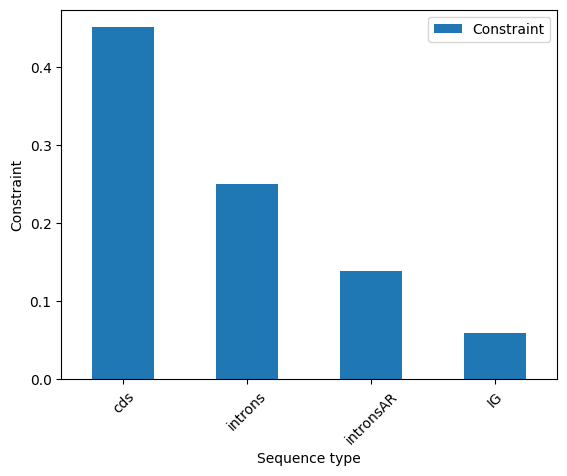

In [10]:
Constraint_data = pd.DataFrame([
    ['cds', (humanENS_cds_IGARQ - humanENS_cds)/humanENS_cds_IGARQ],
    ['introns', (humanENS_introns_IGARQ - humanENS_introns)/humanENS_introns_IGARQ],
    ['intronsAR', (humanENS_intronsAR_IGARQ - humanENS_intronsAR)/humanENS_intronsAR_IGARQ],
    ['IG', (humanENS_IG_IGARQ - humanENS_IG)/humanENS_IG_IGARQ]
    ],
    columns = ['Sequence type', 'Constraint'])

Constraint_data.plot(
    x='Sequence type',
    kind = 'bar',
    rot=45)
plt.ylabel('Constraint')